# Activations and Gradients

Before studing more complex and larger neural networks, like **recurrent neural networks (RNN)** and their variations like the GRU and LSTM, **we will continue at the MLP level** so we have a good understanding of how the **activations** and **gradients** behave during training. This knowledge will explain why RNN are **not easily optimizable** with the first order ingredient-based techniques that we have available to us and that we use all the time.

# Cleaned MLP

Cleaned the code in the previous notebook, [MLP](https://github.com/danielsimon4/language-modeling/blob/main/MLP.ipynb).

In [125]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Load and explore dataset

In [126]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [127]:
len(words)

32033

## Mappinng of characters to/from integers

In [128]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build the dataset

In [129]:
block_size = 3 # context length

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte,  Yte  = build_dataset(words[n2:])   # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## MLP

Same MLP model as the one in the previous notebook, but with variables instead of fix numbers.

In [130]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 11697


In [131]:
max_steps = 30000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  emb = C[Xb]                         # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1          # hidden layer pre-activation
  h = torch.tanh(hpreact)             # hidden layer
  logits = h @ W2 + b2                # output layer
  loss = F.cross_entropy(logits, Yb)  # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01    # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Step:      0 /  30000   Loss: 27.8817
Step:  10000 /  30000   Loss: 2.7754
Step:  20000 /  30000   Loss: 2.4972


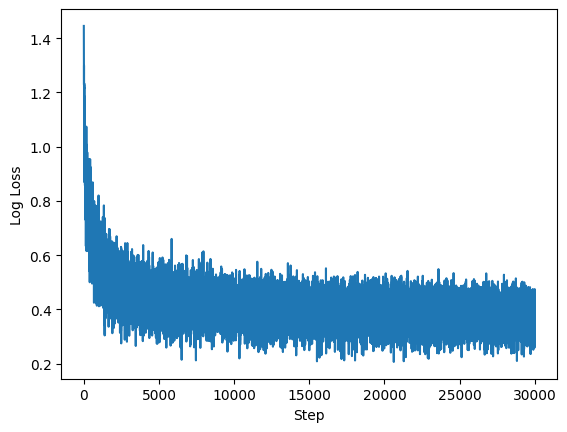

In [132]:
plt.plot(lossi)
plt.xlabel('Step')
plt.ylabel('Log Loss');

Created the function `split_loss(split)` to evaluate the loss of the desired split.

**Note:** *@torch.no_grad()* is a decorator that tells PyToch to not keep track of all the gradients inside the function.

In [133]:
@torch.no_grad()
def split_loss(split):

  # get x,y based on the split
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  # forward pass
  emb = C[x]                          # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)             # (N, n_hidden)
  logits = h @ W2 + b2                # (N, vocab_size)
  loss = F.cross_entropy(logits, y)

  print(split, 'loss:', loss.item())

split_loss('train')
split_loss('val')

train loss: 2.4129655361175537
val loss: 2.4283676147460938


# Fixing initial loss

## Problem

On the step 0 we got a loss of 27. Then, the loss rapidly decreased to 2. **We should expect a lower loss at initialization**.

At initialization we have no reason to believe that any character is much more likely than others. Thus, initially we should expect a uniform probabilty distribution assigning about equal probability (1/27) to all the 27 characters. Hence, we should expect an **initialization loss** close to:

In [134]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

The issue is that at initialization the **logits coming out of the neural net are not uniform** (they are extreme randomly positive or negative numbers). Some characters are very confident and some characters are very not confident so the network is very confidently wrong recording a high loss.

Re-intialize the parameters of the neural net:

In [135]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 11697


Run a single forward pass:

In [136]:
# mini-batch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb]                         # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
hpreact = embcat @ W1 + b1          # hidden layer pre-activation
h = torch.tanh(hpreact)             # hidden layer
logits = h @ W2 + b2                # output layer
loss = F.cross_entropy(logits, Yb)  # loss function

print('Intialization loss:', loss.item())

Intialization loss: 27.881732940673828


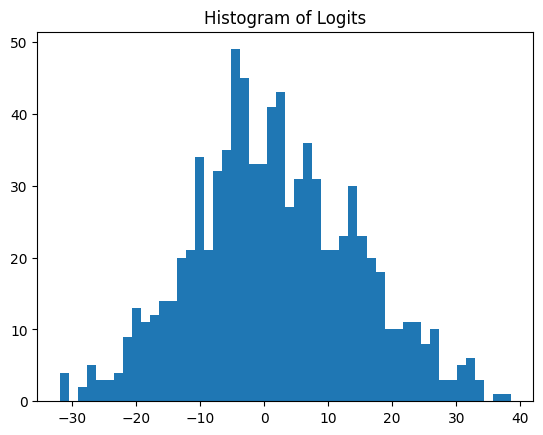

In [137]:
plt.hist(logits.view(-1).tolist(), 50)
plt.title('Histogram of Logits');

## Fix

We have to make the **logits closer to 0 so they are more uniform**.

Remember that *logits = h @ W2 + b2*. 

- Because we want `logits` to be closer to 0 at initialization we can multiply `b2` by 0.

- Because we want `logits` to be closer to 0 at initialization we can multiply `W2` by 0.01.

**Note:** We multiply `W2` by 0.01 instead of 0 so there is some antropy.

In [138]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 11697


## Conclusion

In [139]:
# mini-batch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb]                         # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
hpreact = embcat @ W1 + b1          # hidden layer pre-activation
h = torch.tanh(hpreact)             # hidden layer
logits = h @ W2 + b2                # output layer
loss = F.cross_entropy(logits, Yb)  # loss function

print('Intial loss:', loss.item())

Intial loss: 3.322058916091919


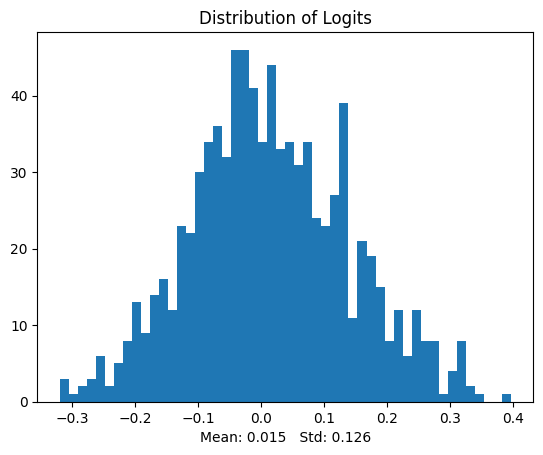

In [140]:
plt.hist(logits.view(-1).tolist(), 50)
plt.title('Distribution of Logits')
plt.xlabel(f'Mean: {logits.mean():.3f}   Std: {logits.std():.3f}');

- The logits coming out of the nueral net are more uniform so the network is less confidently wrong recording a lower initialization loss closer to what we expected (3.2958).
- Train loss and dev loss are lower because we are spending the first several thousand iterations optimizing the neural net instead of just squashing down the weights.

# Fixing saturated tanh

## Problem

Another problem is that many of the **activations of the hidden layer** `h` are 1 or -1. Thas it because the **pre-activations** `hpreact` take numbers between -15 and 15 making the activations very active (tanh takes arbitrary numbers and squashes them into a range of -1 and 1).

tanh:

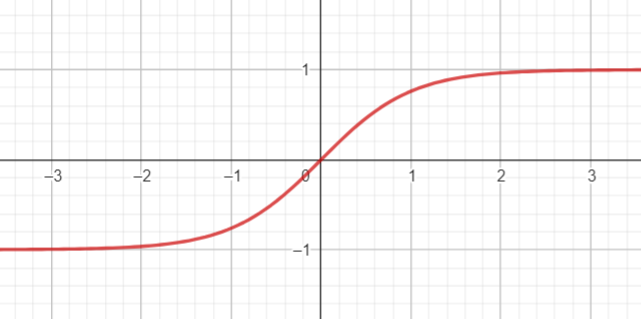

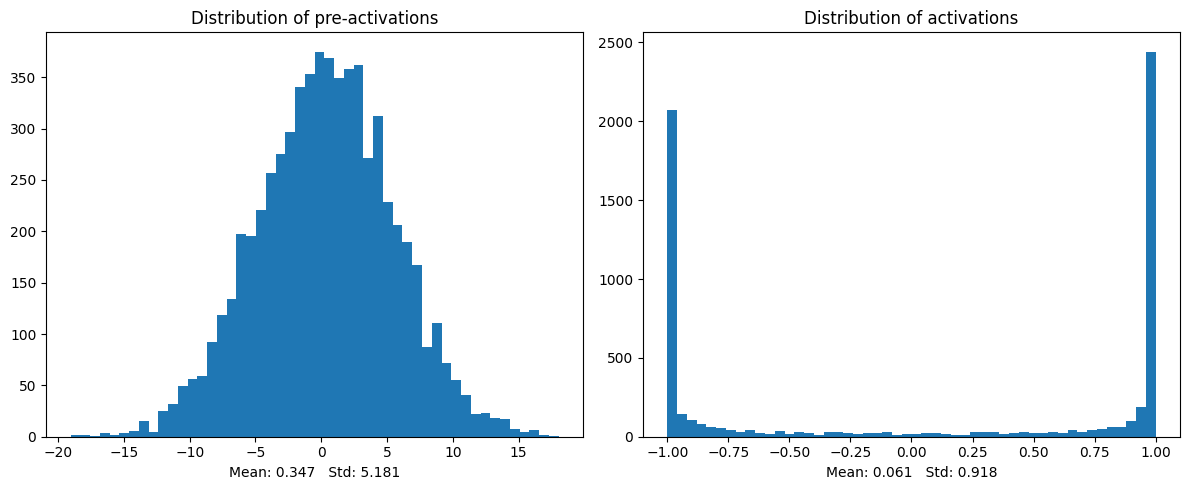

In [141]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('Distribution of pre-activations')
plt.xlabel(f'Mean: {hpreact.mean():.3f}   Std: {hpreact.std():.3f}')

plt.subplot(122)
plt.hist(h.view(-1).tolist(), 50)
plt.title('Distribution of activations')
plt.xlabel(f'Mean: {h.mean():.3f}   Std: {h.std():.3f}')

plt.tight_layout()

The real issue comes in the backward pass when we backpropagate through tanh:

*new gradient = (1 - tanh^2) * gradient*

If the outputs of tanh are very active (1 or -1), the new gradients will be 0, **killing the gradients** and stopping backpropagation through the neuron.

We can visualize the issue. The bits in white mean those neurons where very active destroying the backward gradient for that example. If we had a column of all white bits, we would have a **dead neuron** (no single example ever activates the tanh, in the not flat region, so the neuron is killing all the gradients and it never learns).

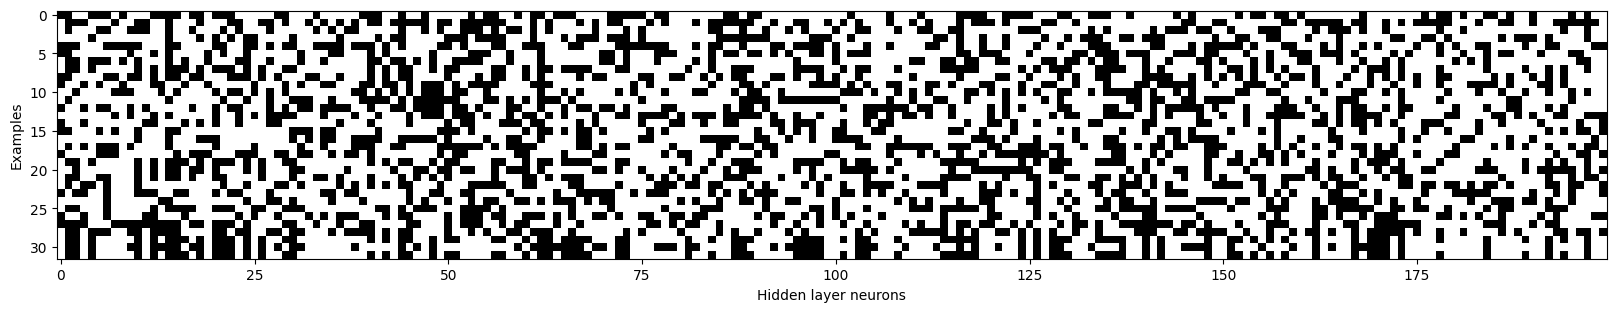

In [142]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Examples');

The problem of dead neurons also applies to other activation functions like Sigmoid or ReLu. It would happen if all the pre-activations would fall in the flat regions of those activation functions. 

This issue can sometimes happen at initialization because the weights and the biases just make it so that by chance some neurons are just forever dead. However, it can also happen during optimization. If you have a too high learning rate some neurons may get too much of a gradient and from then, no example would ever activate them again.

## Example of Kaiming intialization

### Linear layers

As we discussed before, we don't want the pre-activations `hpreact` to be too small or too large because then the activations after tanh would be -1 or 1, and that would kill the gradients during backpropagation. In fact, **we want the activations to be roughly Gaussian** (0 mean and 1 standard deviation) at least at initialization.

When we compute a linear layer *y = x · w* the standard deviation of y grows to 3.

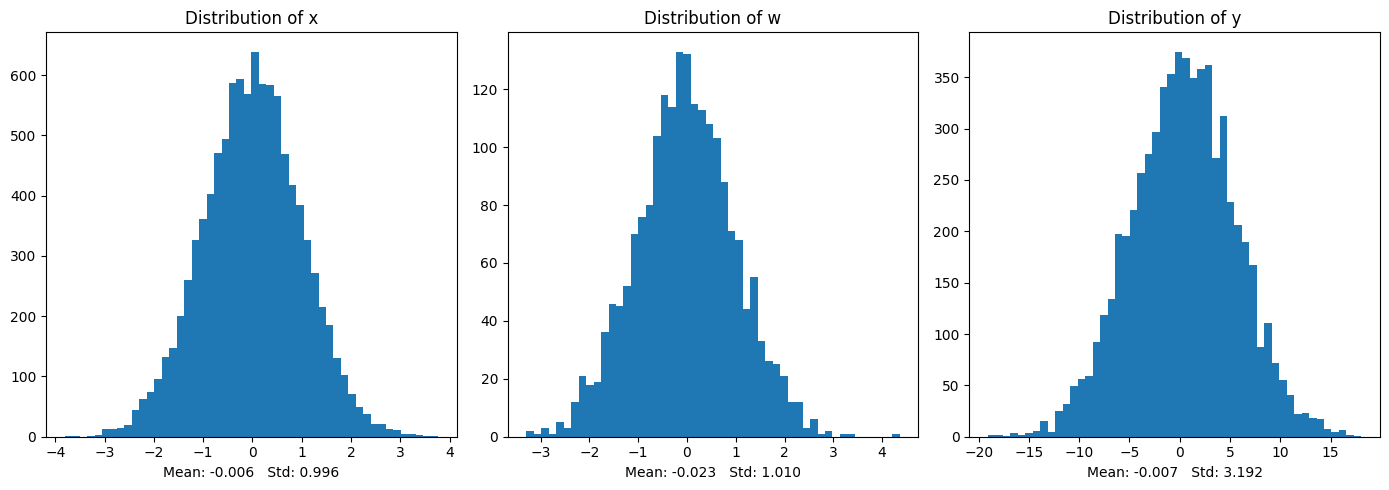

In [143]:
x = torch.randn(1000, 10) # 1000 10 dimensional examples
w = torch.randn(10, 200)  # weights of a 200 neurons hidden layer
y = x @ w

plt.figure(figsize=(14,5))

plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50)
plt.title('Distribution of x')
plt.xlabel(f'Mean: {x.mean():.3f}   Std: {x.std():.3f}')

plt.subplot(132)
plt.hist(w.view(-1).tolist(), 50)
plt.title('Distribution of w')
plt.xlabel(f'Mean: {w.mean():.3f}   Std: {w.std():.3f}')

plt.subplot(133)
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('Distribution of y')
plt.xlabel(f'Mean: {y.mean():.3f}   Std: {y.std():.3f}')

plt.tight_layout()

To keep the standard deviation of y close to 1, we have to divide the weights `w` by the square root of the number of input elements.

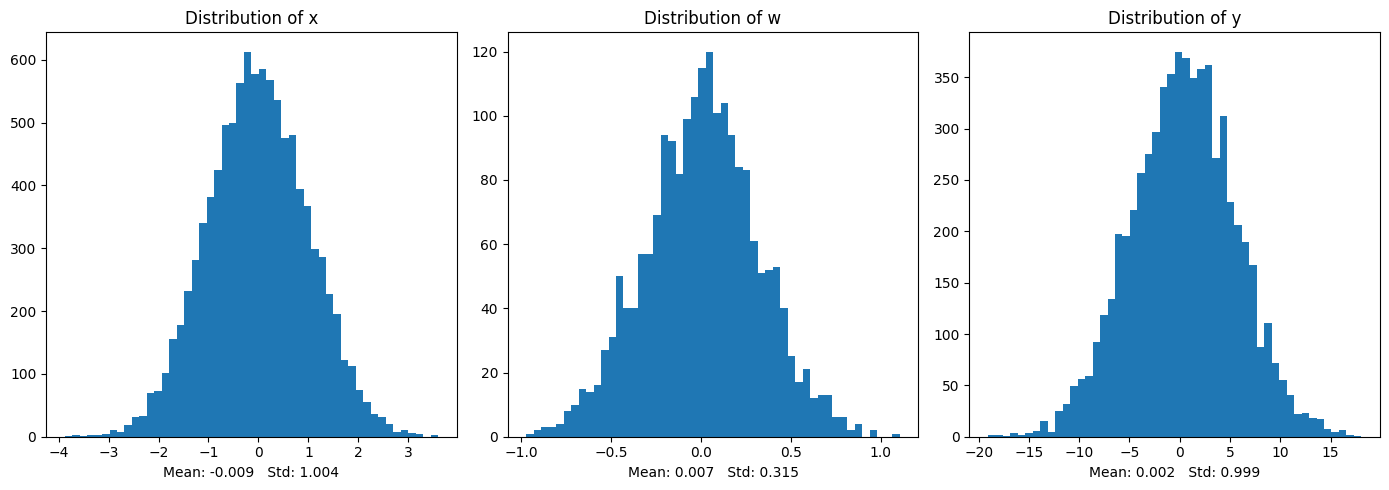

In [144]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

plt.figure(figsize=(14,5))

plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50)
plt.title('Distribution of x')
plt.xlabel(f'Mean: {x.mean():.3f}   Std: {x.std():.3f}')

plt.subplot(132)
plt.hist(w.view(-1).tolist(), 50)
plt.title('Distribution of w')
plt.xlabel(f'Mean: {w.mean():.3f}   Std: {w.std():.3f}')

plt.subplot(133)
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('Distribution of y')
plt.xlabel(f'Mean: {y.mean():.3f}   Std: {y.std():.3f}')

plt.tight_layout()

### Non-linearities

A number of papers have looked into the best way to initialize neural networks. In the case of MLP we can have fairly deep networks that use non-linearities (Tanh, Sigmoid, ReLu, ...) and we want to make sure the activations don't expand to infinity or shrink to zero. 

One known paper that studies the behavior of the activations and gradients that is often referenced is [He et al. (2015). *Delving Deep into Rectifiers*](https://arxiv.org/pdf/1502.01852). It describes **Kaiming initialization**, the most common way of initializing neural networks:

$$
\text{std} = \frac{\text{gain}}{\sqrt{\text{fan-in}}}
$$

- `gain` depends on the nonlinearity.
- `fan-in` is the number of input elements.

<br>

*Why do we multiply by a gain on top?*

Tanh and ReLu are contractive transformations that take the output distribution from the matrix multiplication and squash it. In order to fight the squeezing, we need to boost the weights a little bit.

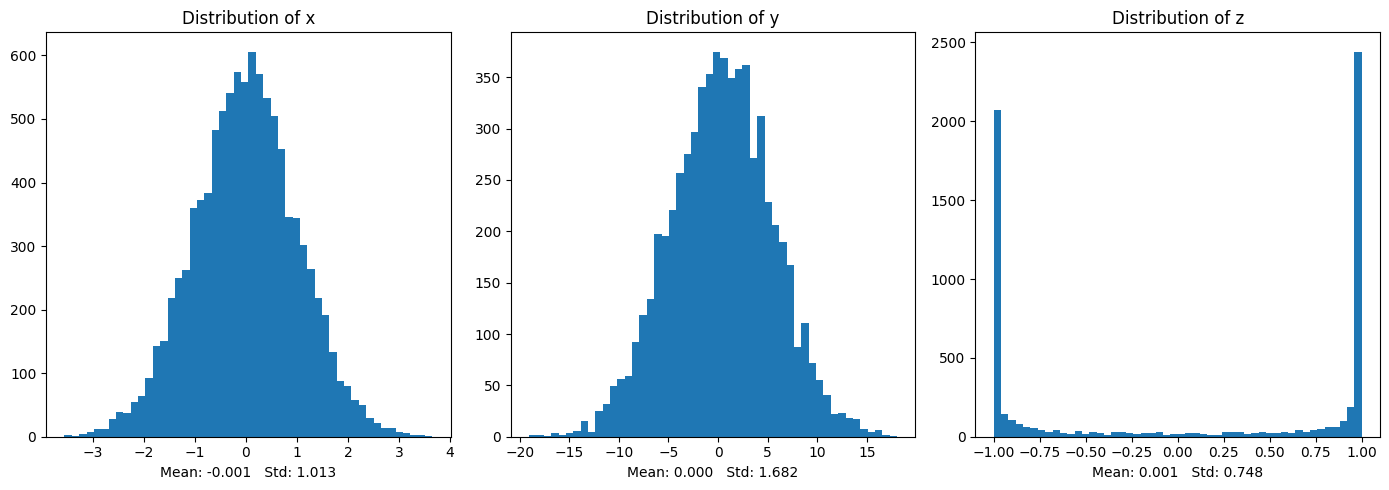

In [145]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * (5/3)/10**0.5
y = x @ w
z = torch.tanh(y)

plt.figure(figsize=(14,5))

plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50)
plt.title('Distribution of x')
plt.xlabel(f'Mean: {x.mean():.3f}   Std: {x.std():.3f}')

plt.subplot(132)
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('Distribution of y')
plt.xlabel(f'Mean: {y.mean():.3f}   Std: {y.std():.3f}')

plt.subplot(133)
plt.hist(h.view(-1).tolist(), 50)
plt.title('Distribution of z')
plt.xlabel(f'Mean: {z.mean():.3f}   Std: {z.std():.3f}')

plt.tight_layout()

**Note:** There are some modern innovations that have made everything significantly more stable and more well-behaved and has become less important to initialize these networks exactly right:

1. Residual connections which we will cover in the future 
2. The use of a number of normalization layers like batch normalization, layer normalization, or group normalization 
3. Much better optimizers like RMS prop and Adam.

## Fix

Kaiming initalization in our neural net: 

In [146]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 11697


## Conclusion

In [147]:
# mini-batch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb]                         # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
hpreact = embcat @ W1 + b1          # hidden layer pre-activation
h = torch.tanh(hpreact)             # hidden layer
logits = h @ W2 + b2                # output layer
loss = F.cross_entropy(logits, Yb)  # loss function

print('Intial loss:', loss.item())

Intial loss: 3.3178884983062744


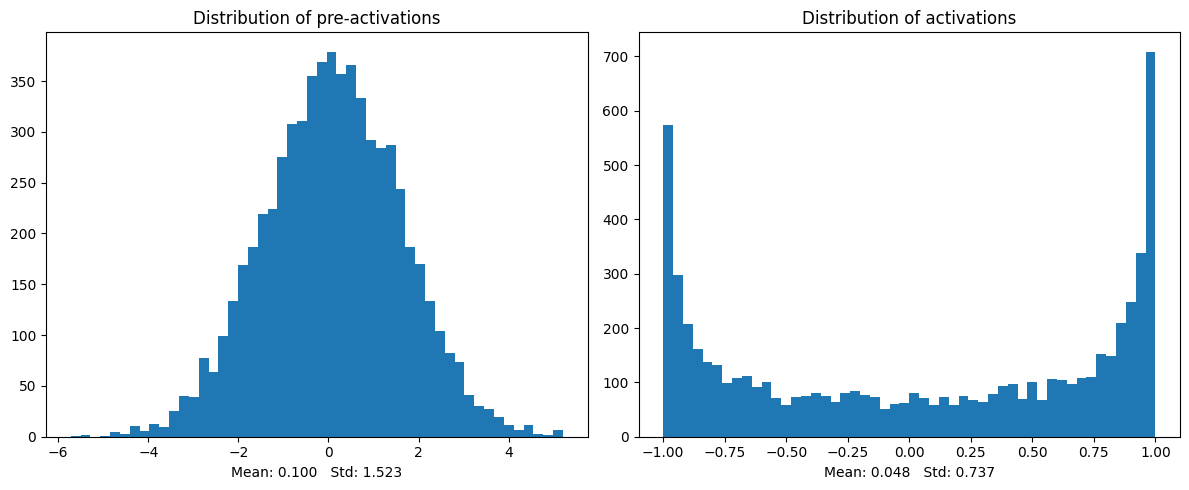

In [148]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('Distribution of pre-activations')
plt.xlabel(f'Mean: {hpreact.mean():.3f}   Std: {hpreact.std():.3f}')

plt.subplot(122)
plt.hist(h.view(-1).tolist(), 50)
plt.title('Distribution of activations')
plt.xlabel(f'Mean: {h.mean():.3f}   Std: {h.std():.3f}')

plt.tight_layout()

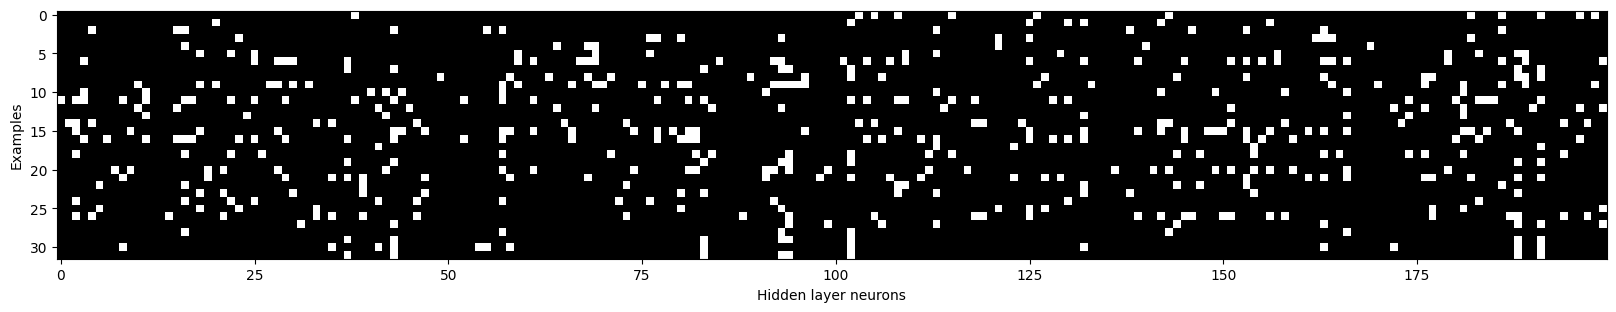

In [149]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.xlabel('Hidden layer neurons')
plt.ylabel('Examples');

- Train loss and dev loss are lower because the neural net is not killing that many gradients at initialization.
- Even though our initialization was terrible, the network still learned eventually. This is not usually the case when working with much deeper networks.

# Batch normalization

Once we have deeper neural net it will become very difficult to tune the scales of the weight matrices using techniques like Kaiming initialization such that all the activations throughout the neural net are roughly Gaussian. Thus, it is common to append **batch normalization layers** throughout the neural net to control the scale of the activations.

The paper [Ioffe and Szegedy. (2015). *Batch normalization*](https://arxiv.org/pdf/1502.03167) introduces the idea of **normalizing the activations** that are feeding into the BatchNorm layer to center that batch to be **unit Gaussian** by substracting the mean and dividing by the standard deviation:

$$
hpreact_{\text{n}} = \frac{hpreact - \mu}{\sigma}
$$

The paper also introduces the idea of **scale and shift** that consists on taking the normalized activations and scaling them by some **gain** and offsetting them by some **bias**:

$$
hpreact_{\text{nss}} = \gamma \cdot hpreact_{\text{n}} + \beta
$$

Because the gain `bngain` is initialized to one and the bias `bnbias` is initialized to zero, at initialization each neuron's activation values will be exactly unit gaussian. During optimization the neural net will be able to backpropagate and change the gain and the bias.

<br>

**Batch normalization "issue":**

The stability offered by batch normalization comes at a terrible cost. We started feeding into our neural net a single example. Because of efficiency of training we started to use batches of examples but they were processed independently. 

In batch normalization, because of the normalization through the batch, **we are coupling these examples mathematically**. Thus, now the activations and logits for any input example are not just a function of that example and its input, but they're also a function of all the other examples in that batch.

This actually turns to be good because it introduces a little bit of entropy (noise) and regularizes the neural net so it does not overfit to the input examples.

<br>

**Calibrate batch norm at the end of training:**

Once we have trained a neural net we would like to be able to feed in a single individual example and get a prediction out from our neural net. But now, with the batch normalization, the neural net expects batches as an input now.

The proposal in the batch normalization paper is to have a step after training that calculates and sets the bact mean and standard deviation a single time over the training set.

<br>

**Calibrate batch norm during training:**

However, nobody wants to estimate the mean and standard deviation as a second stage after neural network training. The batch normalization paper introduced one more idea which is that we can we can estimate the mean and standard deviation in a running manner using `bnmean_running` and `bnstd_running` during the training of the nueral net.

<br>

**Remove bias:**

When using batch normalization layers if you have any weight layers before (like a linear layer or a convolutional layer) you do not want to use bias (whatever bias you add in `hpreact`, it is going to get subtracted later when subtracting `bnmeani`). Instead we have the batch normalizatio bias `bnbias`.

In [150]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))          # batch normalization gain
bnbias = torch.zeros((1, n_hidden))         # batch normalization bias
bnmean_running = torch.zeros((1, n_hidden)) # batch normalization mean
bnstd_running = torch.ones((1, n_hidden))   # batch normalization std

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 12097


In [151]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  emb = C[Xb]                         # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1               # hidden layer pre-activation

  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():               # similar to @torch.no_grad() before
      bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
      bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  # Non-linearity
  h = torch.tanh(hpreact)             # hidden layer
  logits = h @ W2 + b2                # output layer
  loss = F.cross_entropy(logits, Yb)  # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01    # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Step:      0 / 200000   Loss: 3.3239
Step:  10000 / 200000   Loss: 2.0322
Step:  20000 / 200000   Loss: 2.5675
Step:  30000 / 200000   Loss: 2.0125
Step:  40000 / 200000   Loss: 2.2446
Step:  50000 / 200000   Loss: 1.8897
Step:  60000 / 200000   Loss: 2.0785
Step:  70000 / 200000   Loss: 2.3681
Step:  80000 / 200000   Loss: 2.2918
Step:  90000 / 200000   Loss: 2.0238
Step: 100000 / 200000   Loss: 2.3673
Step: 110000 / 200000   Loss: 2.3132
Step: 120000 / 200000   Loss: 1.6414
Step: 130000 / 200000   Loss: 1.9311
Step: 140000 / 200000   Loss: 2.2231
Step: 150000 / 200000   Loss: 2.0027
Step: 160000 / 200000   Loss: 2.0997
Step: 170000 / 200000   Loss: 2.4949
Step: 180000 / 200000   Loss: 2.0199
Step: 190000 / 200000   Loss: 2.1707


In [152]:
@torch.no_grad()
def split_loss(split):

  # get x,y based on the split
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  # forward pass
  emb = C[x]                          # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)             # (N, n_hidden)
  logits = h @ W2 + b2                # (N, vocab_size)
  loss = F.cross_entropy(logits, y)

  print(split, 'loss:', loss.item())

split_loss('train')
split_loss('val')

train loss: 2.0674145221710205
val loss: 2.1056838035583496


# Classes for layers

The classes that we are going to create are very similar to the ones in [torch.nn](https://pytorch.org/docs/stable/nn.html) (PyTorch's API).

In [153]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # kaiming initialization
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])



class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):

    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True)   # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]



class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

## Initialize MLP

In [191]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647)      # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():

  # last layer: make less confident
  layers[-1].weight *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 46497


## Optimize MLP

In [192]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []                           # update to data ratio

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  emb = C[Xb]                     # embed the characters into vectors
  x = emb.view(emb.shape[0], -1)  # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)   # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad()       # DEBUG: retain_grad serves for the graphs
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  
  break                            # DEBUG: break after a single iteration

Step:      0 / 200000   Loss: 3.2988


# Diagnostic Tools

There are some diagnostic tools to understand whether our neural network is in a good state dynamically.

## Activation Distribution

With the ativations, we want all the layers to **stabilize** with a **small saturation**. The first layer is fairly saturated but then everything sort of stabilizes around a standard deviation of 0.66 and a saturation of 6%. The reason why the activations are not shrinking or exploding is because the gain is 5/3.

**Note:** The saturation is the percentage of values that are in the tails of the tanh. We don't want it to be too high since, as we saw before, tanh activations close to 1 or -1 will stop gradients.

layer 1 (Tanh)    mean: -0.04    std: 0.64    saturation: 5.19%
layer 3 (Tanh)    mean: -0.01    std: 0.54    saturation: 0.41%
layer 5 (Tanh)    mean: +0.01    std: 0.53    saturation: 0.47%
layer 7 (Tanh)    mean: -0.02    std: 0.53    saturation: 0.28%
layer 9 (Tanh)    mean: +0.01    std: 0.54    saturation: 0.25%


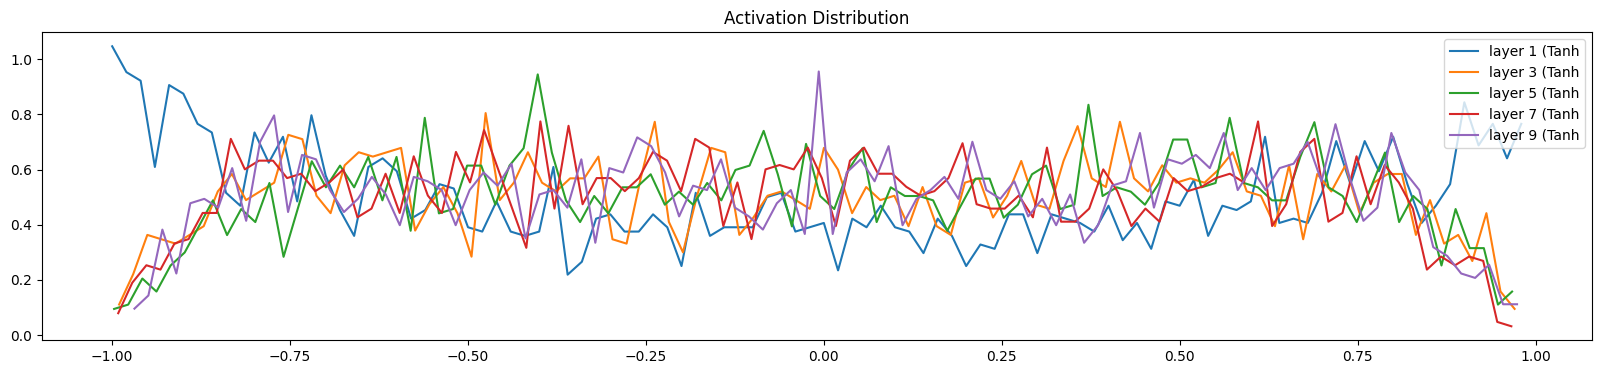

In [193]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%s)    mean: %+.2f    std: %.2f    saturation: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends)
plt.title('Activation Distribution');

### Wrong

Gain = 1 (Shrinking to 0):

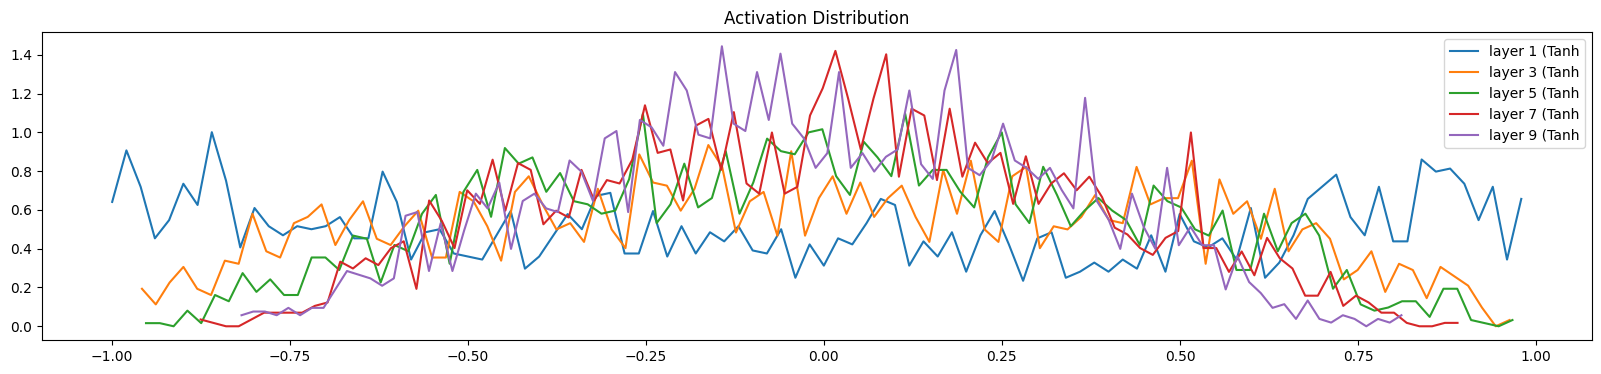

Gain = 3 (Exploting):

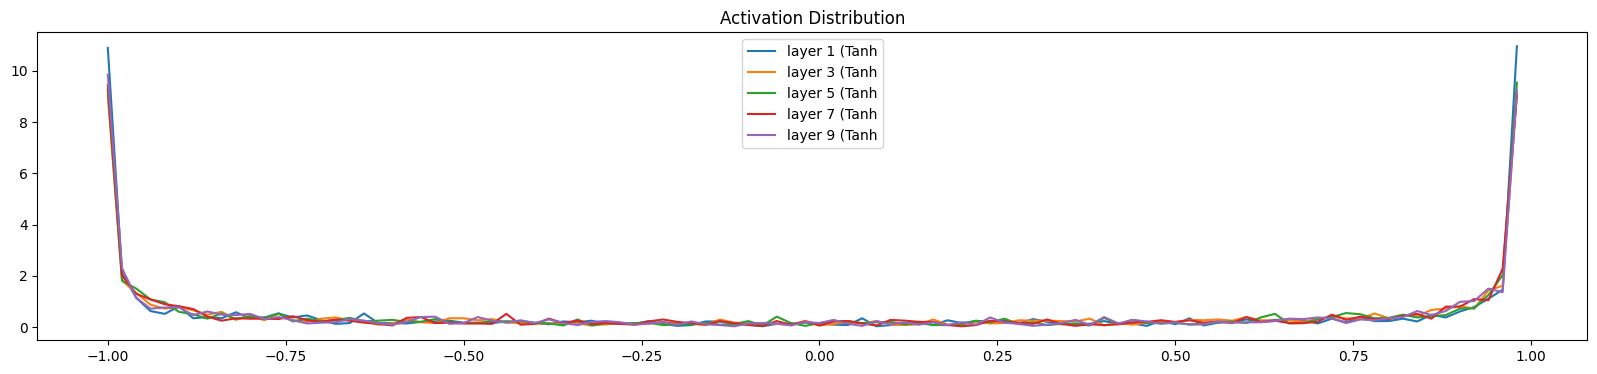

## Gradient Distribution

With the gradients, we want all the layers to **stabilize** with roughly the same **bell distribution**. As the activations, the gradients are not shrinking or exploding.

Layer 1 (Tanh)    mean: +0.000033    std: 0.002642
Layer 3 (Tanh)    mean: +0.000043    std: 0.002441
Layer 5 (Tanh)    mean: -0.000004    std: 0.002338
Layer 7 (Tanh)    mean: +0.000006    std: 0.002284
Layer 9 (Tanh)    mean: +0.000040    std: 0.002059


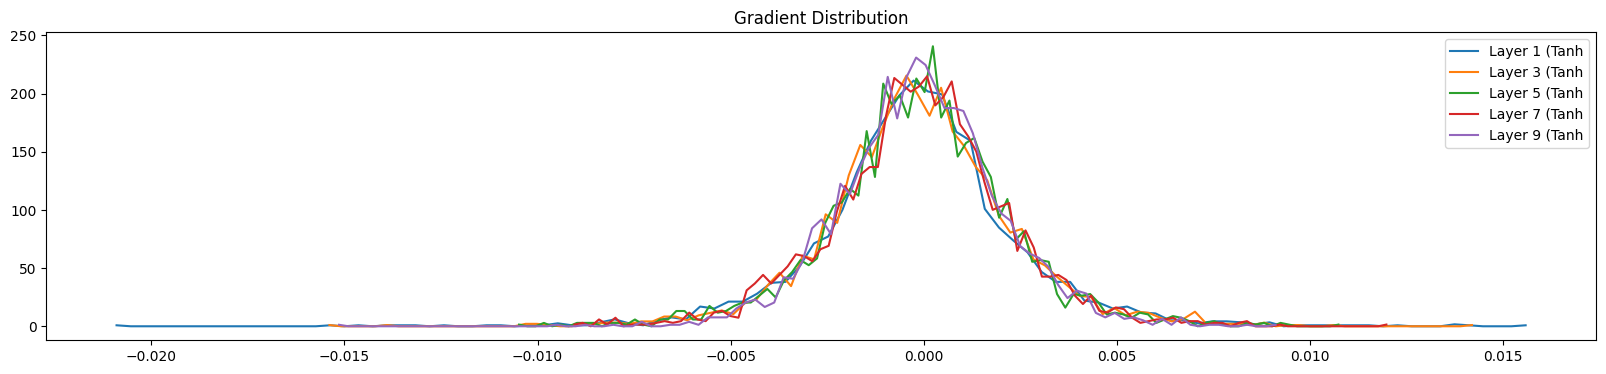

In [195]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('Layer %d (%s)    mean: %+f    std: %f' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends)
plt.title('Gradient Distribution');

### Wrong

Gain = 1 (Exploting):

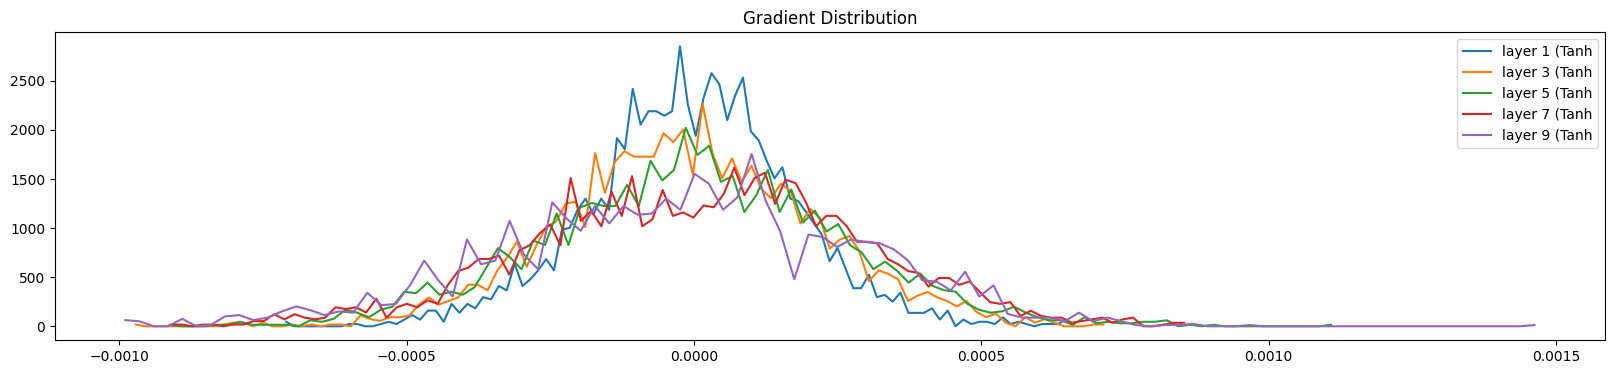

Gain = 3 (Shrinking to 0):

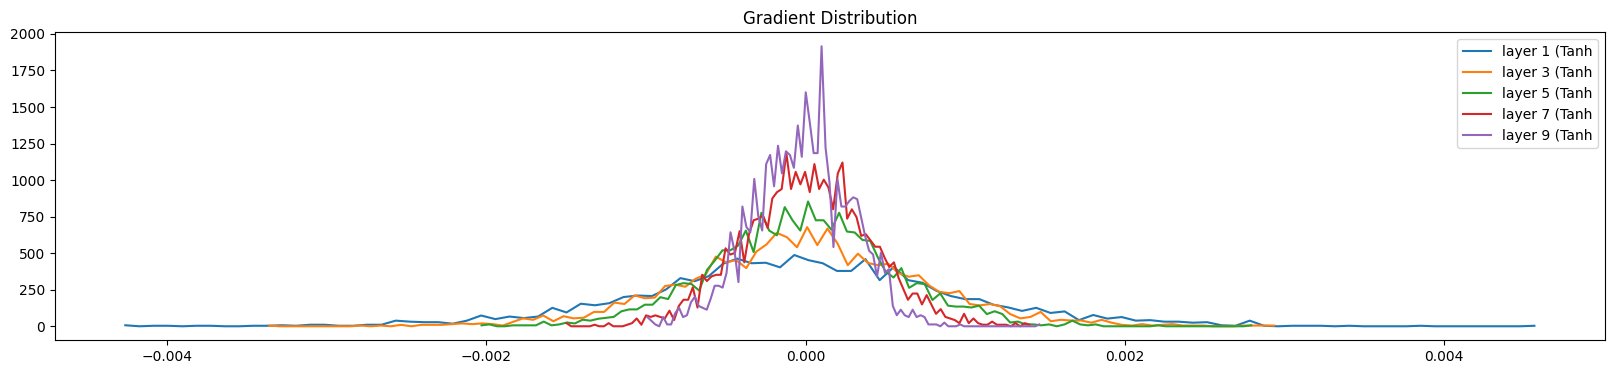

## Weights Gradient Distribution

In this case we are analyzing the **gradients of the weights**.

**Gradient to data (grad:data) ratio** gives a sense of the scale of the gradient compared to the scale of the actual values. In the update step we multiply the learning rate times the gradient (*p.data += -lr * p.grad*). Thus, it is important that the magnitude of the gradients is not too big compared to the magnitude of the data. In our case, the values inside grad are a thousand times smaller than the values inside data (but the last layer).

Weights  0   (27, 10)    mean: -0.000031    std: 0.001365    grad:data ratio: 0.001364
Weights  1  (30, 100)    mean: -0.000049    std: 0.001207    grad:data ratio: 0.003872
Weights  3 (100, 100)    mean: +0.000016    std: 0.001097    grad:data ratio: 0.006602
Weights  5 (100, 100)    mean: -0.000010    std: 0.000989    grad:data ratio: 0.005893
Weights  7 (100, 100)    mean: -0.000011    std: 0.000862    grad:data ratio: 0.005158
Weights  9 (100, 100)    mean: -0.000004    std: 0.000739    grad:data ratio: 0.004415
Weights 11  (100, 27)    mean: +0.000000    std: 0.023648    grad:data ratio: 2.328203


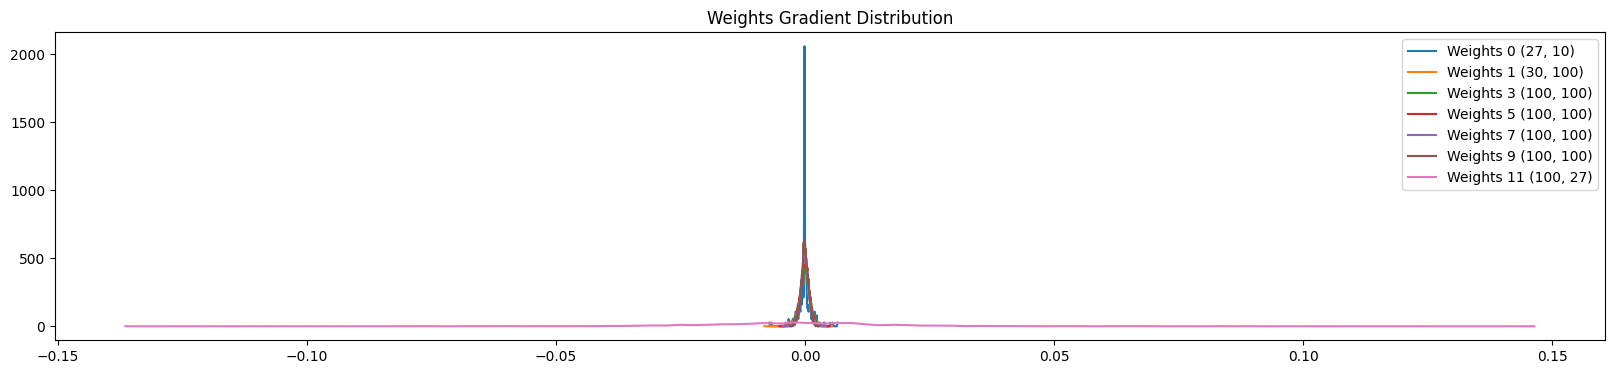

In [158]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
  t = p.grad
  
  if p.ndim == 2: # only the weights
    print('Weights %2d %10s    mean: %+f    std: %f    grad:data ratio: %f' % (i, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Weights {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

### Issue

If we look at the standard deviation, the gradients on the last layer are about ten times grater than all the other gradients. Hence, if we use stochastic gradient descent, we are training the last layer about ten times faster at initialization. This issue fixes itself a little bit if we train a bit longer.

**Note:** A modern optimizer like Adam will not suffer from this issue.

### Train for a 1000 iterations

In [196]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647)      # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():

  # last layer: make less confident
  layers[-1].weight *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 46497


In [197]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []                           # update to data ratio

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  emb = C[Xb]                     # embed the characters into vectors
  x = emb.view(emb.shape[0], -1)  # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)   # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad()       # DEBUG: retain_grad serves for the graphs
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  
  if i >= 1000:
    break                            # DEBUG: break after a thousand iterations

Step:      0 / 200000   Loss: 3.2962


Weights  0   (27, 10)    mean: +0.000980    std: 0.011892    grad:data ratio: 0.011891
Weights  1  (30, 100)    mean: +0.000118    std: 0.010053    grad:data ratio: 0.032146
Weights  3 (100, 100)    mean: +0.000033    std: 0.007821    grad:data ratio: 0.046534
Weights  5 (100, 100)    mean: -0.000107    std: 0.006656    grad:data ratio: 0.039259
Weights  7 (100, 100)    mean: -0.000017    std: 0.006086    grad:data ratio: 0.036058
Weights  9 (100, 100)    mean: -0.000077    std: 0.005076    grad:data ratio: 0.030153
Weights 11  (100, 27)    mean: -0.000000    std: 0.020566    grad:data ratio: 0.290991


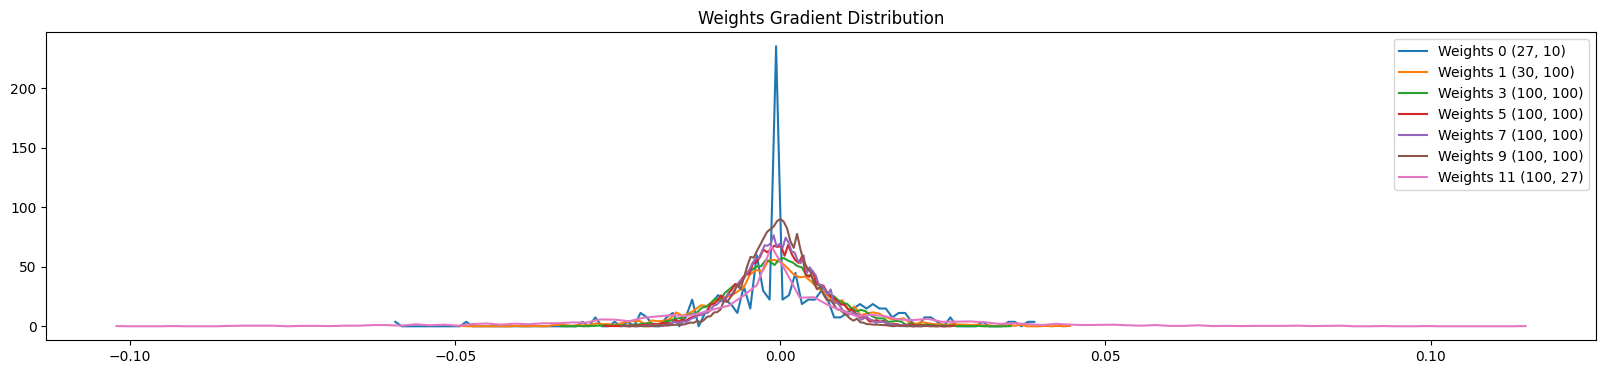

In [198]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
  t = p.grad
  
  if p.ndim == 2: # only the weights
    print('Weights %2d %10s    mean: %+f    std: %f    grad:data ratio: %f' % (i, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Weights {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

## Step vs Update to data ratio

The gradient to data ratio is actually not that informative. What matters at the end is the **update to the data ratio**, the amount by which we will actually change the data in these tensors.

The update to data ratio should be around -3 (black line).

**Note:** The reason that the final layer here is an outlier is because this layer was artificially shrunk down in the initialization to keep the softmax income unconfident.

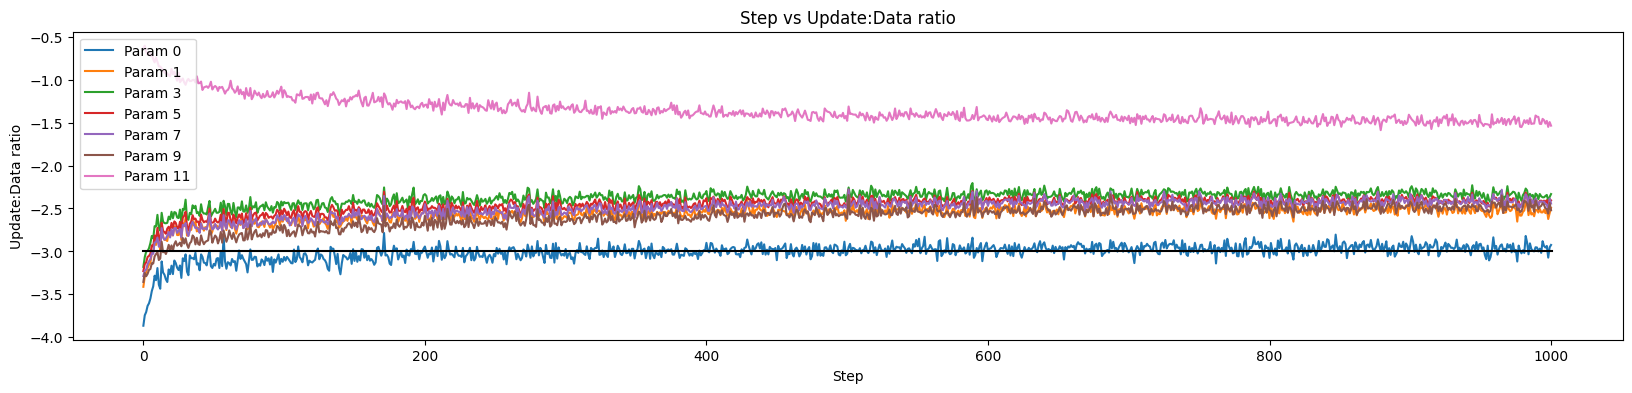

In [199]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append(f'Param {i}')

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Step vs Update:Data ratio')
plt.xlabel('Step')
plt.ylabel('Update:Data ratio');

### Wrong

Learning rate = 0.001 (learning too slow):

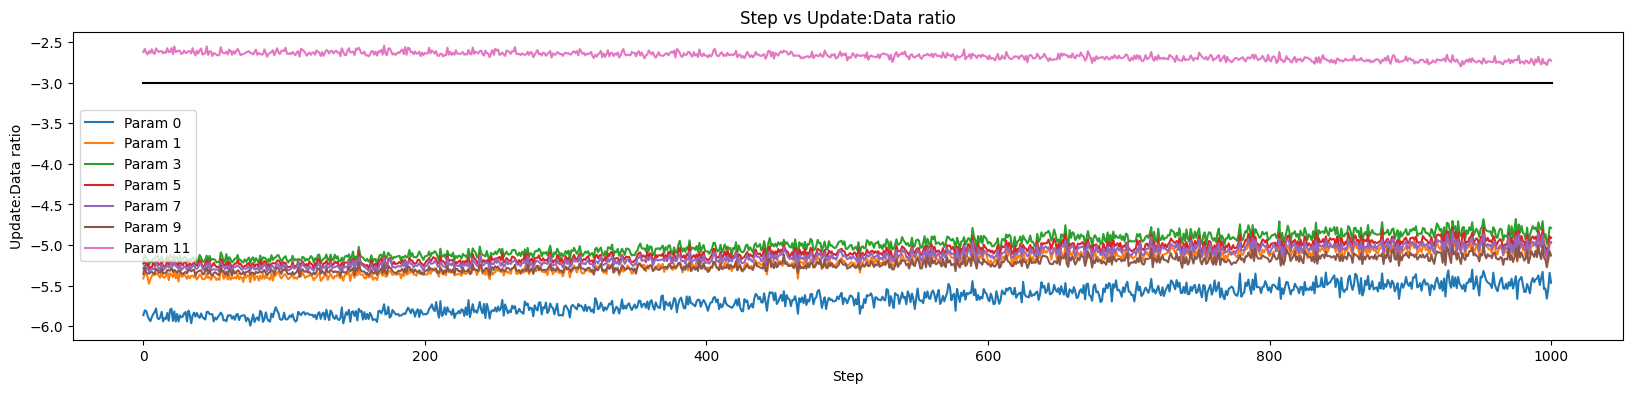

# Including batch normalization layers

With batch normalization layers the neural network the activations and gradients are better behaved. In addition, the nerual net is significantly more robust to a change in the gain. We could also remove the division of the weights by the square root of the number of input elements at initialization but we would have to increase the learning rate.

In [207]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647)      # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():

  # last layer: make less confident
  layers[-1].gamma *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
  p.requires_grad = True

print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 47024


In [208]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []                           # update to data ratio

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  # forward pass
  emb = C[Xb]                     # embed the characters into vectors
  x = emb.view(emb.shape[0], -1)  # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)   # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad()       # DEBUG: retain_grad serves for the graphs
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'Step:{i:7d} /{max_steps:7d}   Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  
  if i >= 1000:
    break                            # DEBUG: break after a thousand iterations

Step:      0 / 200000   Loss: 3.2870


layer 2 (Tanh)    mean: -0.00    std: 0.63    saturation: 2.62%
layer 5 (Tanh)    mean: +0.00    std: 0.64    saturation: 2.47%
layer 8 (Tanh)    mean: -0.00    std: 0.64    saturation: 2.16%
layer 11 (Tanh)    mean: +0.00    std: 0.65    saturation: 1.81%
layer 14 (Tanh)    mean: -0.00    std: 0.65    saturation: 1.78%


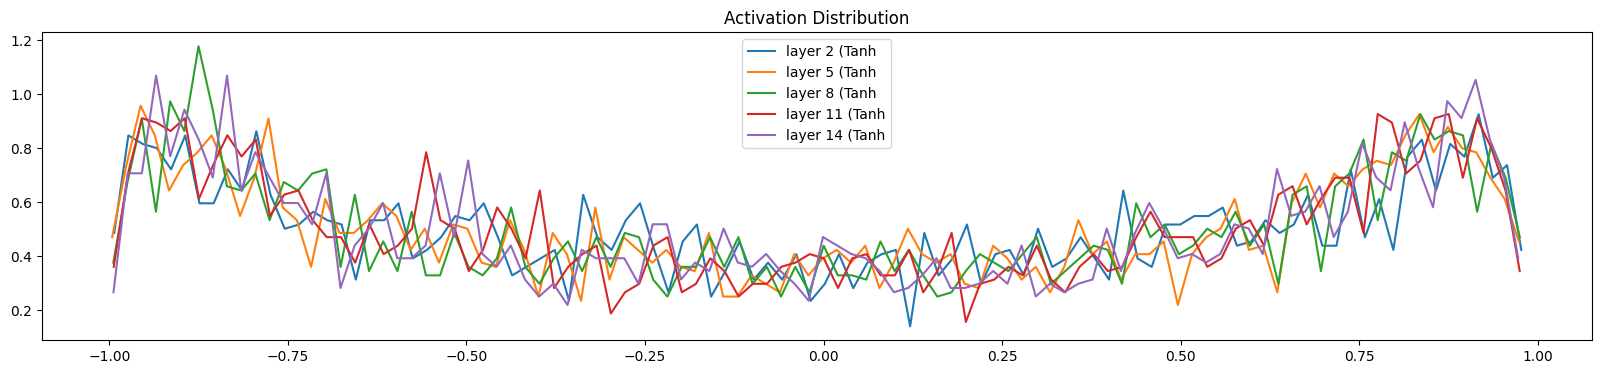

In [202]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%s)    mean: %+.2f    std: %.2f    saturation: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends)
plt.title('Activation Distribution');

Layer 2 (Tanh)    mean: -0.000000    std: 0.003683
Layer 5 (Tanh)    mean: -0.000000    std: 0.003263
Layer 8 (Tanh)    mean: -0.000000    std: 0.002974
Layer 11 (Tanh)    mean: +0.000000    std: 0.002741
Layer 14 (Tanh)    mean: +0.000000    std: 0.002584


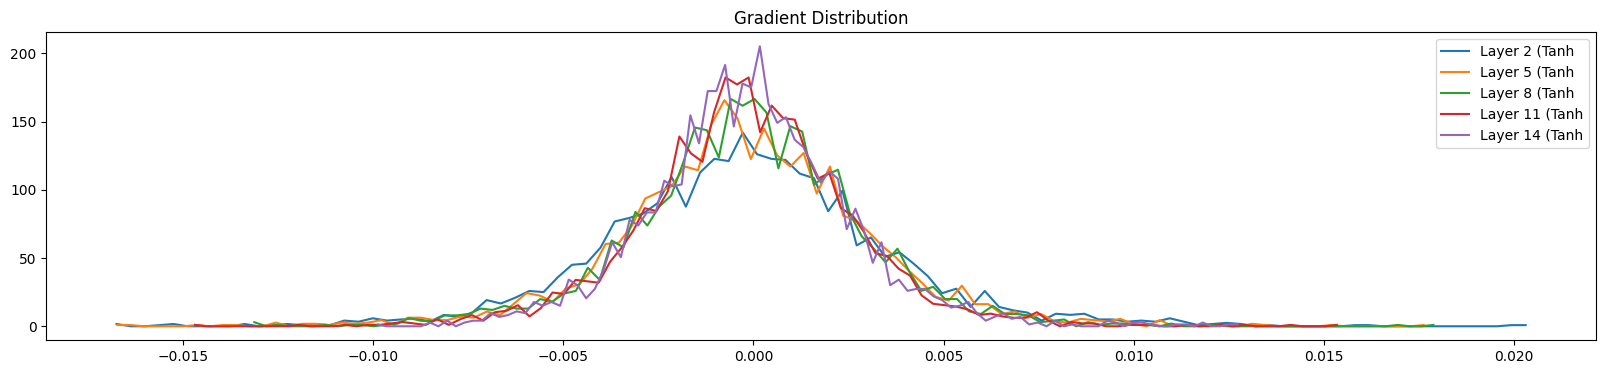

In [209]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('Layer %d (%s)    mean: %+f    std: %f' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends)
plt.title('Gradient Distribution');

Weights  0   (27, 10)    mean: +0.000000    std: 0.010199    grad:data ratio: 0.010188
Weights  1  (30, 100)    mean: +0.000092    std: 0.008238    grad:data ratio: 0.026358
Weights  4 (100, 100)    mean: +0.000031    std: 0.007318    grad:data ratio: 0.043772
Weights  7 (100, 100)    mean: -0.000019    std: 0.006662    grad:data ratio: 0.039499
Weights 10 (100, 100)    mean: -0.000019    std: 0.005822    grad:data ratio: 0.034682
Weights 13 (100, 100)    mean: +0.000053    std: 0.005445    grad:data ratio: 0.032434
Weights 16  (100, 27)    mean: -0.000165    std: 0.010468    grad:data ratio: 0.062813


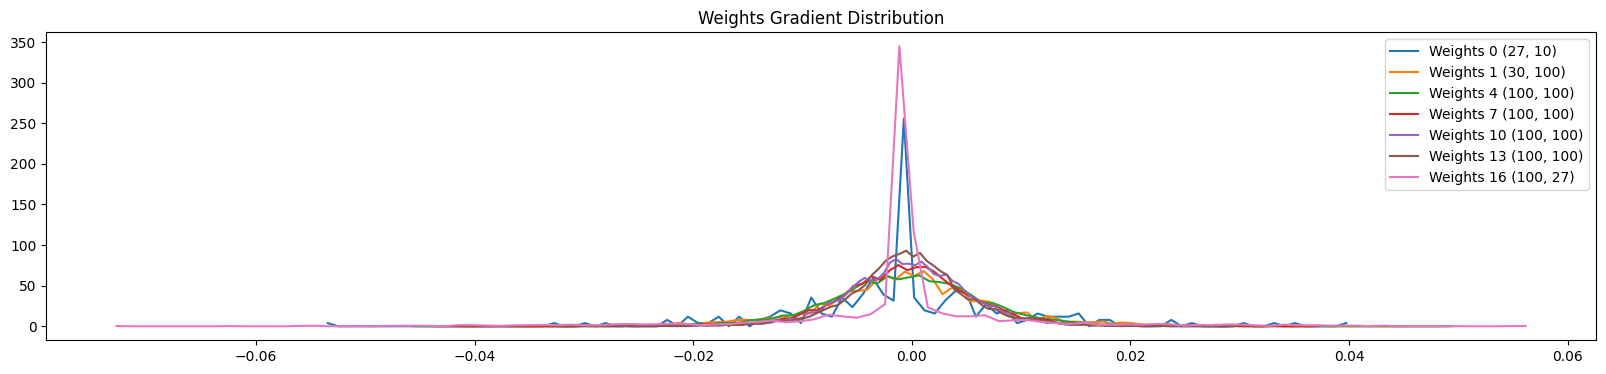

In [204]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
  t = p.grad
  
  if p.ndim == 2: # only the weights
    print('Weights %2d %10s    mean: %+f    std: %f    grad:data ratio: %f' % (i, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Weights {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

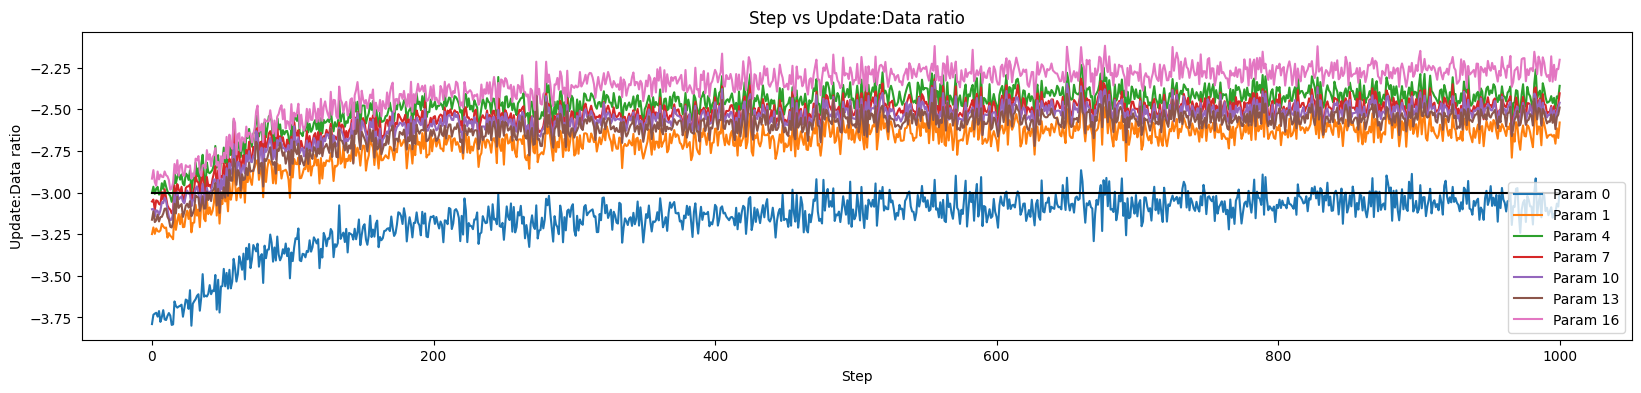

In [206]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append(f'Param {i}')

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Step vs Update:Data ratio')
plt.xlabel('Step')
plt.ylabel('Update:Data ratio');